# SBB

In [1]:
%matplotlib inline
import os
import pandas as pd
import matplotlib.pyplot as plt
#from mpl_toolkits.basemap import Basemap
import numpy as np
import networkx as nx

## Import Data

In [2]:
df = pd.read_csv('data/zugzahlen.csv')
df.head(5)

,PID,ISB,Strecke_Nummer,Strecke_Bezeichnung,Strecke_Art,BP_Von_Abschnitt,BP_Von_Abschnitt_Bezeichnung,BP_Bis_Abschnitt,BP_Bis_Abschnitt_Bezeichnung,Anzahl_Zuege,...,TU Nummer,Bedienpunkt Cargo,land,Haltestelle,Gde Nummer,gdnr,TU Abkuerzung,Tarifhaltestelle,geopos_von,geopos_bis
0,SBB_GESE_CHY,SBB,1,Genève Aéroport - Lausanne,STRECKE,GESE,Genève-Sécheron,CHY,Chambésy,126307,...,11,None,Switzerland,*,6621,6621,SBB CFF FFS,None,"6.14454714955, 46.2224480511","6.14732717469, 46.2423883571"
1,SBB_GIBU_ROL,SBB,1,Genève Aéroport - Lausanne,STRECKE,GIBU,Gilly-Bursinel,ROL,Rolle,97943,...,11,None,Switzerland,None,5852,5852,SBB CFF FFS,None,"6.30636755445, 46.4450640594","6.3364074853, 46.4627442908"
2,SBB_MIES_TAN,SBB,1,Genève Aéroport - Lausanne,STRECKE,MIES,Mies,TAN,Tannay,126101,...,11,None,Switzerland,*,5723,5723,SBB CFF FFS,None,"6.16956925257, 46.2998837999","6.18111951391, 46.3076442488"
3,SBB_MOR_STJ,SBB,1,Genève Aéroport - Lausanne,STRECKE,MOR,Morges,STJ,Morges-St-Jean,121566,...,11,*,Switzerland,*,5642,5642,SBB CFF FFS,None,"6.49396657295, 46.5110943408","6.5080466068, 46.5181943179"
4,SBB_PER_ALL,SBB,1,Genève Aéroport - Lausanne,STRECKE,PER,Perroy,ALL,Allaman,98005,...,11,None,Switzerland,None,5860,5860,SBB CFF FFS,None,"6.3629973972, 46.4712243911","6.3997071623, 46.4757445942"


In [3]:
df['lon_von'] = df.geopos_von.str.split('\,').str[0]
df['lon_von'] = df['lon_von'].map(float)

In [4]:
df['lat_von'] = df.geopos_von.str.split('\,').str[1]
df['lat_von'] = df['lat_von'].map(float)

In [5]:
df['lon_bis'] = df.geopos_bis.str.split('\,').str[0]
df['lon_bis'] = df['lon_bis'].map(float)

In [6]:
df['lat_bis'] = df.geopos_bis.str.split('\,').str[1]
df['lat_bis'] = df['lat_bis'].map(float)

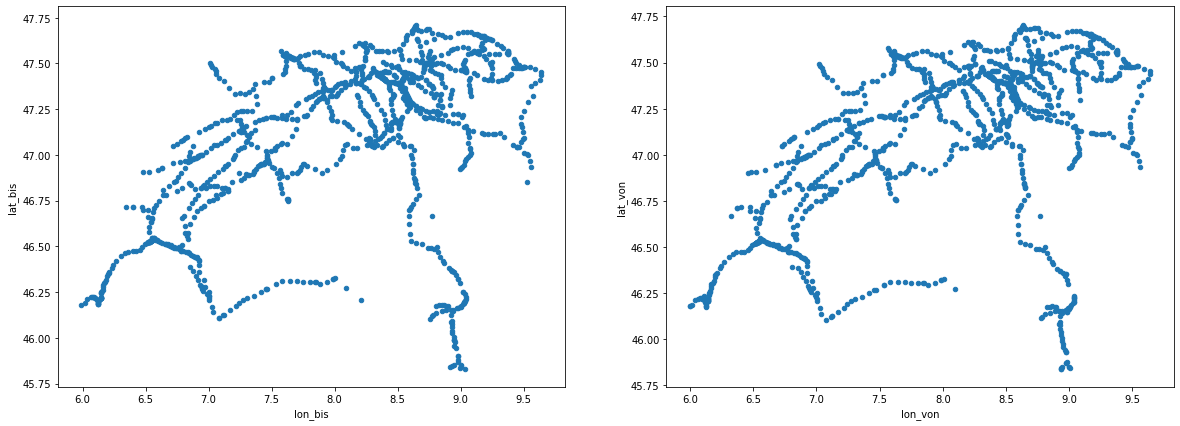

In [7]:
fig, axes = plt.subplots(figsize = (20,7), nrows=1, ncols=2);
df.plot.scatter(ax=axes[1], x='lon_von', y ='lat_von');
df.plot.scatter(ax=axes[0], x='lon_bis', y ='lat_bis');

In [8]:
pos_von = {}
for i in range(0, len(df)):
    pos_von[df.BP_Von_Abschnitt[i]] = (df.lon_von[i], df.lat_von[i])

In [9]:
pos_bis = {}
for i in range(0, len(df)):
    pos_bis[df.BP_Bis_Abschnitt[i]] = (df.lon_bis[i], df.lat_bis[i])

In [10]:
# Magic merge of dictionaries
pos = {**pos_bis, **pos_von}

## Building the Network

In [11]:
import warnings
warnings.filterwarnings('ignore')

In [12]:
D = nx.from_pandas_edgelist(df, source = 'BP_Von_Abschnitt', target = 'BP_Bis_Abschnitt', edge_attr = 'Anzahl_Zuege', create_using = nx.DiGraph())

In [13]:
G = nx.Graph(D)

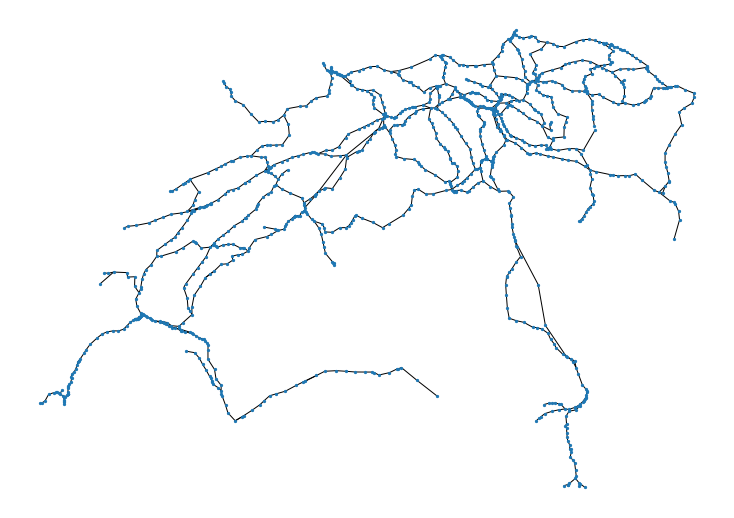

In [14]:
plt.figure(figsize = (10,7))
nx.draw(G, pos=pos, with_labels=False, node_size=5)

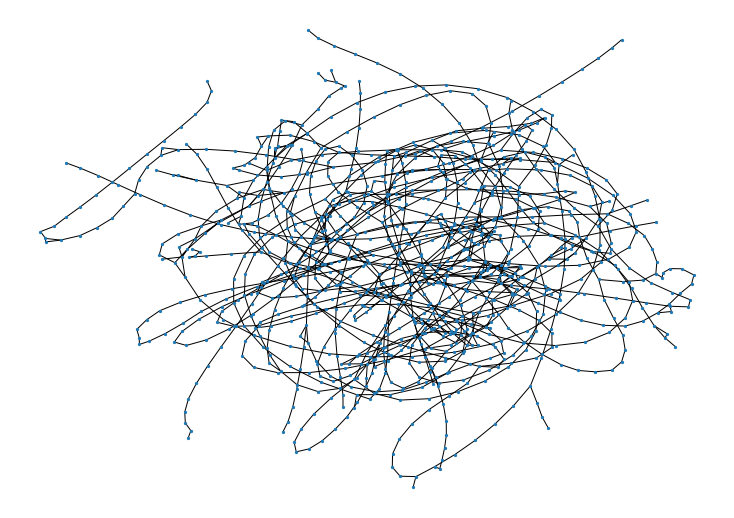

In [15]:
plt.figure(figsize = (10,7))
nx.draw(G, with_labels=False, node_size=5)